In [1]:
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import plotly.express as px
from gensim.models import Word2Vec
from fastai.tabular.all import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.patches as mpatches

sns.set()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


206 Reactivity columns

In [2]:
rna_sequence_data = pd.read_csv('/kaggle/input/stanford-ribonanza-rna-folding/train_data.csv', nrows = 25000)
rna_sequence_data.head()

,sequence_id,sequence,experiment_type,dataset_name,reads,signal_to_noise,SN_filter,reactivity_0001,reactivity_0002,reactivity_0003,...,reactivity_error_0197,reactivity_error_0198,reactivity_error_0199,reactivity_error_0200,reactivity_error_0201,reactivity_error_0202,reactivity_error_0203,reactivity_error_0204,reactivity_error_0205,reactivity_error_0206
0,8cdfeef009ea,GGGAACGACUCGAGUAGAGUCGAAAAACGUUGAUAUGGAUUUACUCCGAGGAGACGAACUACCACGAACAGGGGAAACUCUACCCGUGGCGUCUCCGUUUGACGAGUAAGUCCUAAGUCAACAUGCCACGCGGGUCCUUCGGGACCCGCAAAAGAAACAACAACAACAAC,2A3_MaP,15k_2A3,2343,0.944,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,51e61fbde94d,GGGAACGACUCGAGUAGAGUCGAAAAACAUUGAUAUGGAUUUACUCCGAGGAGACGAACUACCACGAACAGGGGAAACUCUACCCGUGGCGUCUCCGUUUGACGAGUAAGUCCUAAGUCAACAUGCACAGCGCUGGGUUCGCCCAGCGCAAAAGAAACAACAACAACAAC,2A3_MaP,15k_2A3,5326,1.933,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,25ce8d5109cd,GGGAACGACUCGAGUAGAGUCGAAAAACCUUGAUAUGGAUUUACUCCGAGGAGACGAACUACCACGAACAGGGGAAACUCUACCCGUGGCGUCUCCGUUUGACGAGUAAGUCCUAAGUCAACAUGCAUGGGUCCUCCUUCGGGAGGACCAAAAGAAACAACAACAACAAC,2A3_MaP,15k_2A3,4647,2.347,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,07dcfb6d1965,GGGAACGACUCGAGUAGAGUCGAAAAACUUUGAUAUGGAUUUACUCCGAGGAGACGAACUACCACGAACAGGGGAAACUCUACCCGUGGCGUCUCCGUUUGACGAGUAAGUCCUAAGUCAACAUGCCAGGUAUUGACUUCGGUCAAUACAAAAGAAACAACAACAACAAC,2A3_MaP,15k_2A3,102843,11.824,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,e561cc042a4c,GGGAACGACUCGAGUAGAGUCGAAAAACGAUGAUAUGGAUUUACUCCGAGGAGACGAACUACCACGAACAGGGGAAACUCUACCCGUGGCGUCUCCGUUUGACGAGUAAGUCCUAAGUCAACAUGCAUGCAUGCGGCUUCGGCCGCAUGAAAAGAAACAACAACAACAAC,2A3_MaP,15k_2A3,7665,3.519,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
rna_sequence_data = rna_sequence_data.drop(columns=rna_sequence_data.filter(like='error').columns)
rna_sequence_data = rna_sequence_data.drop(['sequence_id', 'dataset_name', 'reads', 'SN_filter'], axis=1)
reactivity_cols = rna_sequence_data.filter(like='reactivity').columns
rna_sequence_data[reactivity_cols] = rna_sequence_data[reactivity_cols].clip(lower=0)
rna_sequence_data['reactivity'] = rna_sequence_data[reactivity_cols].mean(axis=1)
rna_sequence_data = rna_sequence_data.drop(columns=reactivity_cols)
rna_sequence_data

/tmp/ipykernel_25/3587882890.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rna_sequence_data['reactivity'] = rna_sequence_data[reactivity_cols].mean(axis=1)


,sequence,experiment_type,signal_to_noise,reactivity
0,GGGAACGACUCGAGUAGAGUCGAAAAACGUUGAUAUGGAUUUACUCCGAGGAGACGAACUACCACGAACAGGGGAAACUCUACCCGUGGCGUCUCCGUUUGACGAGUAAGUCCUAAGUCAACAUGCCACGCGGGUCCUUCGGGACCCGCAAAAGAAACAACAACAACAAC,2A3_MaP,0.944,0.181534
1,GGGAACGACUCGAGUAGAGUCGAAAAACAUUGAUAUGGAUUUACUCCGAGGAGACGAACUACCACGAACAGGGGAAACUCUACCCGUGGCGUCUCCGUUUGACGAGUAAGUCCUAAGUCAACAUGCACAGCGCUGGGUUCGCCCAGCGCAAAAGAAACAACAACAACAAC,2A3_MaP,1.933,0.208680
2,GGGAACGACUCGAGUAGAGUCGAAAAACCUUGAUAUGGAUUUACUCCGAGGAGACGAACUACCACGAACAGGGGAAACUCUACCCGUGGCGUCUCCGUUUGACGAGUAAGUCCUAAGUCAACAUGCAUGGGUCCUCCUUCGGGAGGACCAAAAGAAACAACAACAACAAC,2A3_MaP,2.347,0.213602
3,GGGAACGACUCGAGUAGAGUCGAAAAACUUUGAUAUGGAUUUACUCCGAGGAGACGAACUACCACGAACAGGGGAAACUCUACCCGUGGCGUCUCCGUUUGACGAGUAAGUCCUAAGUCAACAUGCCAGGUAUUGACUUCGGUCAAUACAAAAGAAACAACAACAACAAC,2A3_MaP,11.824,0.197893
4,GGGAACGACUCGAGUAGAGUCGAAAAACGAUGAUAUGGAUUUACUCCGAGGAGACGAACUACCACGAACAGGGGAAACUCUACCCGUGGCGUCUCCGUUUGACGAGUAAGUCCUAAGUCAACAUGCAUGCAUGCGGCUUCGGCCGCAUGAAAAGAAACAACAACAACAAC,2A3_MaP,3.519,0.210427
...,...,...,...,...
24995,GGGAACGACUCGAGUAGAGUCGAAAAUUGAUCUUUCAGUAGCUUCUACCUAUUUUUUAGUCCGCAUCUUGCAAGAUAAGACUGGCGACUUUAUGUCUACAAUUAUUACUUCCUGCCAAACUGCUGUACGCUUUGCCGUUCGCGGCAAAGAAAAGAAACAACAACAACAAC,DMS_MaP,3.594,0.422932
24996,GGGAACGACUCGAGUAGAGUCGAAAAAGUAGCUUCUACCUAUUUUUUAGUCCGCAUCUUGCAAGAUAAGACUGGCGACUUUAUGUCUACAAUUAUUACUUCCUGCCAAACUGCUGUUAGUAAGCUUAGCCAGACGGGUUCGCCCGUCUGAAAAGAAACAACAACAACAAC,DMS_MaP,2.503,0.515359
24997,GGGAACGACUCGAGUAGAGUCGAAAAACCUAUUUUUUAGUCCGCAUCUUGCAAGAUAAGACUGGCGACUUUAUGUCUACAAUUAUUACUUCCUGCCAAACUGCUGUUAGUAAGCUUCUAGAUACAUUAACGUCGUACUUCGGUACGACGAAAAGAAACAACAACAACAAC,DMS_MaP,4.911,0.516806
24998,GGGAACGACUCGAGUAGAGUCGAAAAUAGUCCGCAUCUUGCAAGAUAAGACUGGCGACUUUAUGUCUACAAUUAUUACUUCCUGCCAAACUGCUGUUAGUAAGCUUCUAGAUACAUGUUUUGAAGCAAAUCGGCUGCUUCGGCAGCCGAAAAAGAAACAACAACAACAAC,DMS_MaP,3.130,0.519029


# Codon Frequency Plot

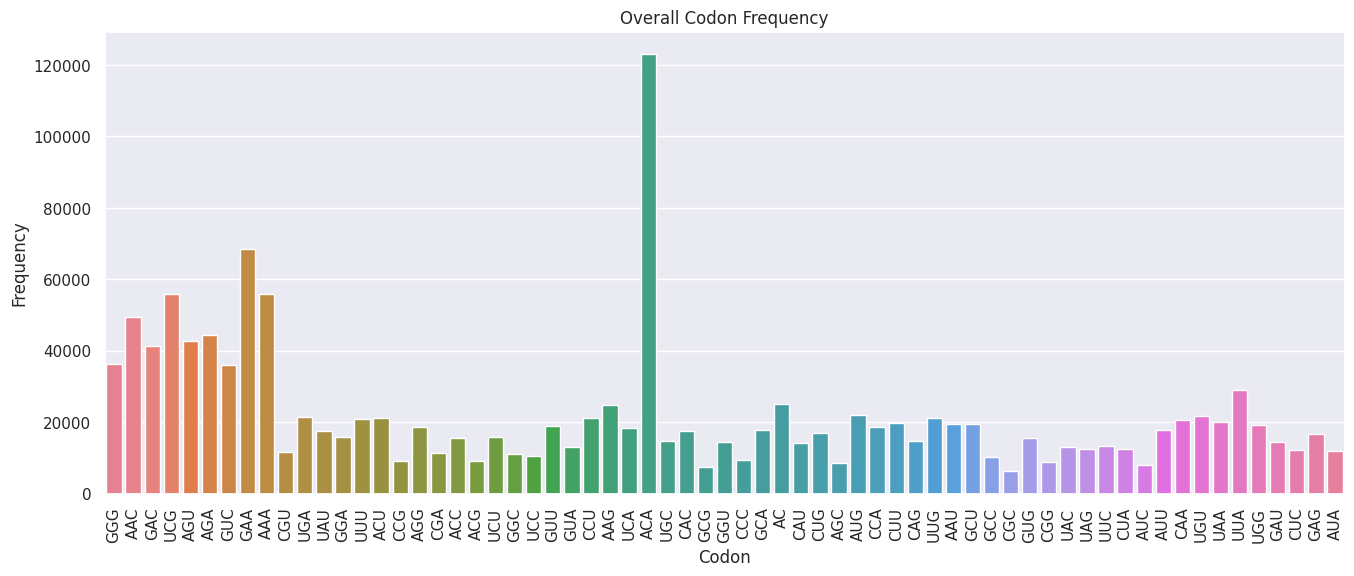

In [4]:
overall_frequency = Counter()

for index, row in rna_sequence_data.iterrows():
    sequence = row['sequence']
    codons = [sequence[i:i+3] for i in range(0, len(sequence), 3)]
    frequency = Counter(codons)
    
    overall_frequency.update(frequency)

custom_palette = sns.color_palette("husl", len(overall_frequency))

plt.figure(figsize=(16, 6))
sns.barplot(x=list(overall_frequency.keys()), y=list(overall_frequency.values()), palette=custom_palette)
plt.xticks(rotation=90)
plt.xlabel('Codon')
plt.ylabel('Frequency')
plt.title('Overall Codon Frequency')
plt.show()

# Codon Heatmap

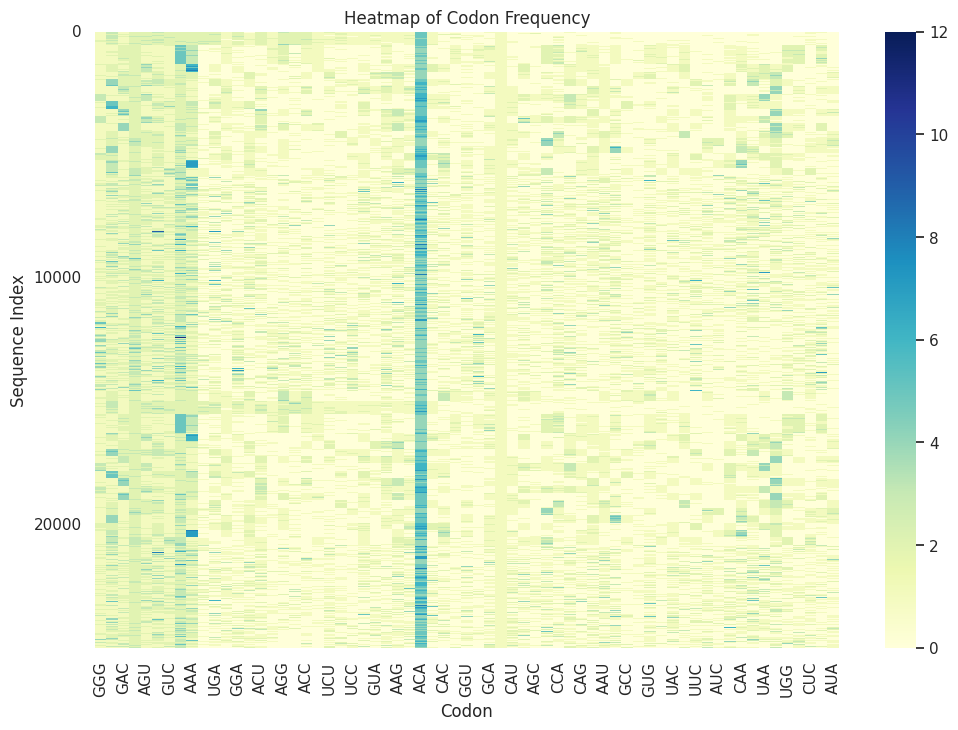

In [5]:
sequences = rna_sequence_data['sequence']

codon_freqs = []
for sequence in sequences:
    codons = [sequence[i:i+3] for i in range(0, len(sequence), 3)]
    frequency = Counter(codons)
    codon_freqs.append(frequency)

df = pd.DataFrame(codon_freqs).fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(df, cmap="YlGnBu")
plt.title('Heatmap of Codon Frequency')
plt.xlabel('Codon')

interval = 10000
plt.yticks(range(0, len(sequences), interval), range(0, len(sequences), interval))

plt.ylabel('Sequence Index')
plt.show()

# Nucleotide level heatmap

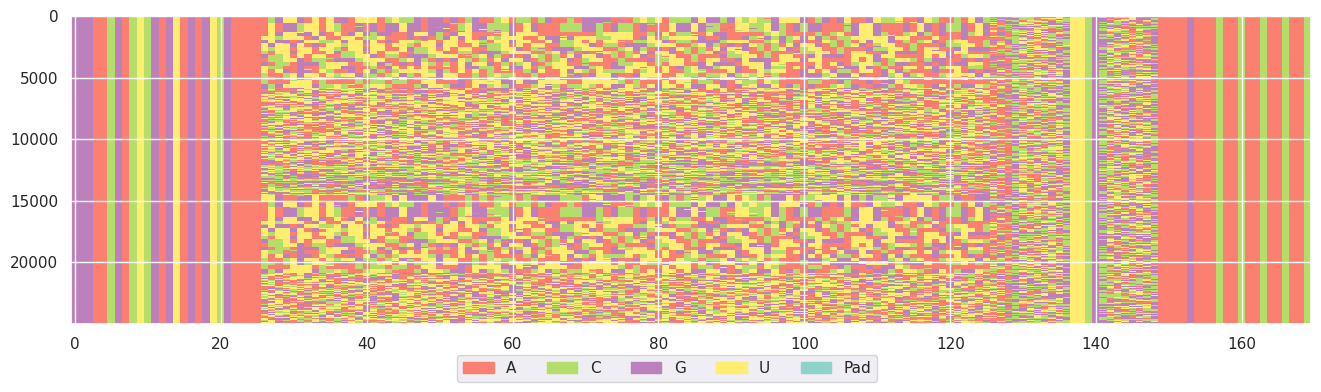

In [6]:
# nucleotides mapping
mapping = {
    'A': 1,
    'C': 2,
    'G': 3,
    'U': 4,
    '.': 0
}

SEQUENCE_LENGTH = 170
numerical_sequences = rna_sequence_data['sequence'].apply(lambda x: [mapping[n] for n in x[:SEQUENCE_LENGTH]])
rna_map = np.array(numerical_sequences.tolist())

CMAP = 'Set3'

plt.figure(figsize=(16,4))
im = plt.imshow(rna_map, aspect='auto', cmap=CMAP, vmin=0, vmax=4, interpolation='nearest')

rna_values = {
    1: 'A',
    2: 'C',
    3: 'G',
    4: 'U',
    0: 'Pad'
}

color_values = [1, 2, 3, 4, 0]
colors = [im.cmap(im.norm(color_value)) for color_value in color_values]
patches = [mpatches.Patch(color=colors[i], label=rna_values[color_value]) for i, color_value in enumerate(color_values)]
plt.legend(handles=patches, bbox_to_anchor=(0.65, -0.1), ncol=5, borderaxespad=0.)
plt.show()

# Composition of A,U,G,C Nucleotides

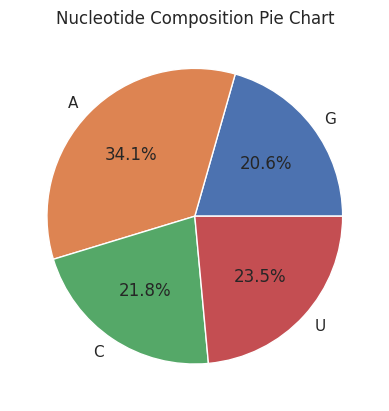

In [7]:
nucleotide_counts = Counter(sequence)

plt.pie(nucleotide_counts.values(), labels=nucleotide_counts.keys(), autopct='%1.1f%%')
plt.title('Nucleotide Composition Pie Chart')
plt.show()

## GC Bond Counts on Sliding window = 30

* GC bonds are more stronger than AT and AU bonds. 
* Strong GC Bonds are stable in high-temperature regions. (Organisms having more GC Bonds in DNA or RNA are more likely to survive in high temperature regions.)
* GC bond abundant regions are more challenging to replicate leading to errors in replication.

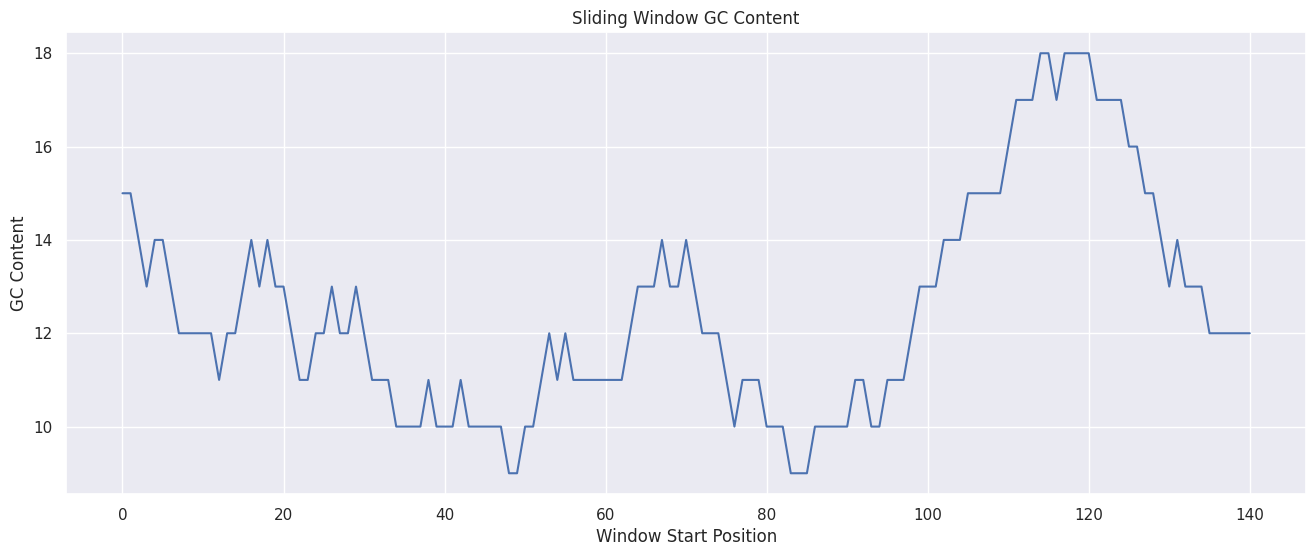

In [8]:
window_size = 30 
gc_content = [sequence[i:i+window_size].count('G') + sequence[i:i+window_size].count('C') for i in range(len(sequence) - window_size + 1)]

plt.figure(figsize=(16, 6))
plt.plot(gc_content)
plt.xlabel('Window Start Position')
plt.ylabel('GC Content')
plt.title('Sliding Window GC Content')
plt.show()

# Bias due to Codon Pair Interaction

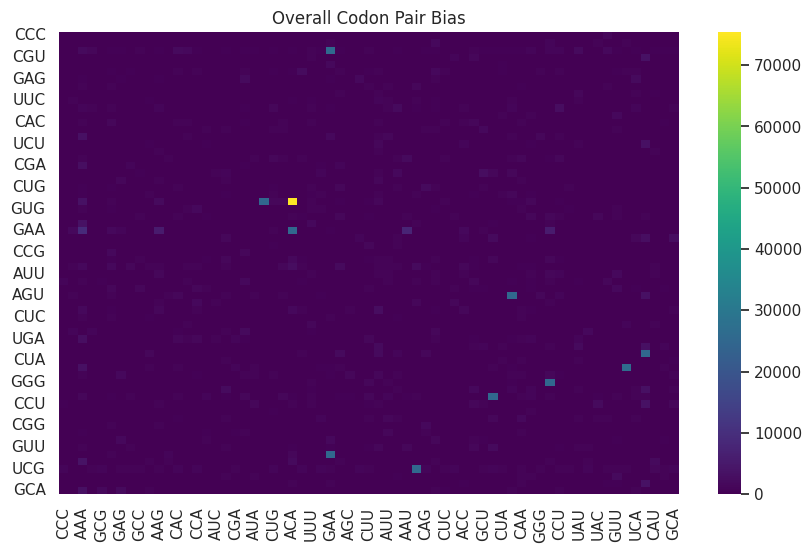

In [9]:
overall_pair_freqs = Counter()

for seq in rna_sequence_data['sequence']:
    pairs = [(seq[i:i+3], seq[i+3:i+6]) for i in range(0, len(seq) - 3, 3)]
    overall_pair_freqs.update(pairs)

index = list(set([pair[0] for pair in overall_pair_freqs.keys()]))
columns = list(set([pair[1] for pair in overall_pair_freqs.keys()]))
pair_df = pd.DataFrame(index=index, columns=columns).fillna(0)

for pair, freq in overall_pair_freqs.items():
    pair_df.at[pair[0], pair[1]] = freq
    
plt.figure(figsize=(10, 6))
sns.heatmap(pair_df, cmap='viridis')
plt.title('Overall Codon Pair Bias')
plt.show()

# 3D Scatter Plot of Codon Counts for AUG, GCA, and GCU Codons

In [10]:
codon_counts = defaultdict(list)

for seq in rna_sequence_data['sequence']:
    counter = Counter([seq[i:i+3] for i in range(0, len(seq), 3)])
    
    for codon in counter:
        codon_counts[codon].append(counter[codon])

for codon, counts in codon_counts.items():
    while len(counts) < len(rna_sequence_data['sequence']):
        counts.append(0)

codon_count = pd.DataFrame(dict(codon_counts))

fig = px.scatter_3d(codon_count, x='AUG', y='GCA', z='GCU')
fig.show()

# Create Embeddings (Word2Vec)

In [11]:
def sequence_to_kmers(sequence, k=3):
    """Convert sequence to overlapping k-mers."""
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

kmers = rna_sequence_data['sequence'].apply(sequence_to_kmers)

model = Word2Vec(sentences=kmers, vector_size=100, window=5, min_count=1, workers=4)

def sequence_to_vector(sequence, model):
    kmers = sequence_to_kmers(sequence)
    vectors = [model.wv[kmer] for kmer in kmers if kmer in model.wv]
    return sum(vectors) / len(vectors)

In [12]:
rna_sequence_data['vectors'] = rna_sequence_data['sequence'].apply(lambda x: sequence_to_vector(x, model))

In [13]:
rna_sequence_data = rna_sequence_data.dropna(subset=['reactivity'])

cols_to_drop = ['sequence', 'experiment_type', 'signal_to_noise']
experiment_2A3_MaP = rna_sequence_data[rna_sequence_data['experiment_type'] == '2A3_MaP'].drop(columns=cols_to_drop).reset_index(drop=True)
experiment_DMS_MaP = rna_sequence_data[rna_sequence_data['experiment_type'] == 'DMS_MaP'].drop(columns=cols_to_drop).reset_index(drop=True)

In [14]:
experiment_DMS_MaP.head()

,reactivity,vectors
0,0.399738,"[-0.19617155, -0.25096253, 0.12405465, 0.3194762, 0.10936502, -0.08804209, 0.13622929, -0.16846208, 0.08579781, 0.018848976, 0.17344598, -0.32299608, 0.07839088, -0.016726099, -0.15193252, -0.24988611, 0.018779173, -0.3679343, 0.068438984, 0.032471675, -0.027724221, 0.14938173, 0.36308882, -0.1634043, 0.0190708, -0.030001434, 0.09894169, -0.24902928, -0.060574446, 0.22560094, 0.01431121, -0.32002506, 0.1928228, 0.056029625, 0.06284784, -0.20779498, -0.47355148, 0.12345735, -0.2997738, 0.0527538, -0.13497566, -0.24317473, 0.1827381, 0.4099082, 0.02467745, 0.06543506, 0.32590222, -0.20974758..."
1,0.543544,"[-0.16132328, -0.18851969, 0.047620513, 0.2139324, 0.033628054, -0.116947696, 0.04444977, -0.20792991, 0.14011697, 0.041445356, 0.1602289, -0.39497018, 0.10268131, 0.01990774, -0.055084966, -0.20557734, -0.010943905, -0.19299343, 0.041299343, -0.0025322128, 0.1395569, 0.15210447, 0.36560333, -0.19216235, -0.0061631417, 0.03498607, 0.15190367, -0.18729344, 0.034466416, 0.198104, -0.017746303, -0.26372993, 0.20028326, 0.03479125, 0.104825646, -0.15548508, -0.33706102, 0.14376354, -0.39811662, 0.11198391, -0.14059901, -0.25904843, 0.1255883, 0.35594442, 0.014043294, 0.0046839067, 0.2114546, -..."
2,0.562961,"[-0.3196451, -0.15602674, 0.07402168, 0.29637152, 0.052602857, -0.10619797, 0.13212696, -0.18125713, 0.09608884, 0.06285856, 0.17173111, -0.2692755, 0.10275138, 0.020602845, -0.17842814, -0.30698907, -0.048408225, -0.44778946, 0.05536321, -0.012626929, 0.046616413, 0.18812473, 0.39817137, -0.2670829, 0.036095403, -0.12568635, 0.1878651, -0.24727803, 0.053000905, 0.2157989, 0.0033448662, -0.32695183, 0.15019423, -0.025508592, 0.115354836, -0.21859828, -0.48155323, 0.22791255, -0.2719504, 0.1506216, -0.08192891, -0.28482753, 0.06346039, 0.4522105, 0.0062746042, 0.050335266, 0.35140544, -0.27..."
3,0.456039,"[-0.28633642, -0.059687376, 0.0020029098, 0.16629966, -0.032182366, -0.13242391, 0.12247183, -0.14760375, 0.22571513, 0.079969846, 0.15879437, -0.30318964, 0.054102615, 0.043091327, -0.13920781, -0.25812134, 0.0460105, -0.38644108, 0.033641897, -0.045058053, 0.03476553, 0.18803838, 0.39377117, -0.3920001, 0.016351126, -0.06627315, 0.2220289, -0.19475512, 0.06826398, 0.23537558, -0.04918077, -0.28257194, 0.17775142, -0.01772318, 0.03916046, -0.24545366, -0.47642154, 0.17812522, -0.2747741, 0.2344712, -0.027295493, -0.2724668, -0.028220166, 0.4573151, -0.0148391975, -0.03269522, 0.31345755, ..."
4,0.488864,"[-0.18062271, -0.16339508, 0.06138948, 0.19878864, 0.05424388, -0.046242625, 0.082162485, -0.11964427, 0.11355944, 0.11507732, 0.18246463, -0.3934137, 0.11026365, 0.016986478, -0.11942911, -0.29656592, 0.08914705, -0.183895, 0.13938752, 0.057439476, -0.022450713, 0.22775818, 0.45495105, -0.2688556, -0.015191737, -0.031363234, 0.10749444, -0.21026559, -0.055455998, 0.15733369, 0.062020678, -0.36570677, 0.1714265, -0.01104477, 0.11885535, -0.08891736, -0.37603736, 0.1366246, -0.44122702, 0.12732996, -0.05555462, -0.2615171, 0.13662161, 0.46118006, -0.032752547, 0.02743612, 0.18473639, -0.157..."


# Approaching it with average Reactivity

epoch,train_loss,valid_loss,mae,time
0,0.010540,0.003181,0.042776,00:01


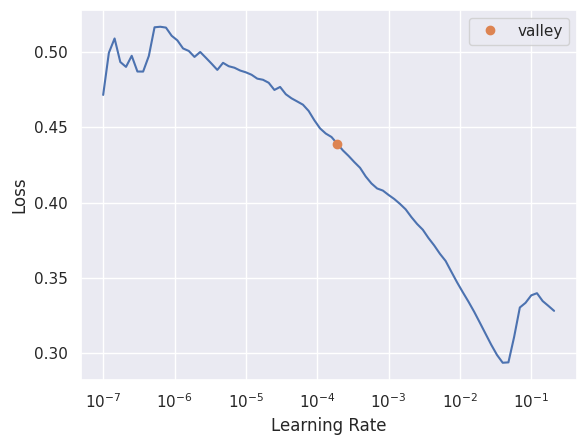

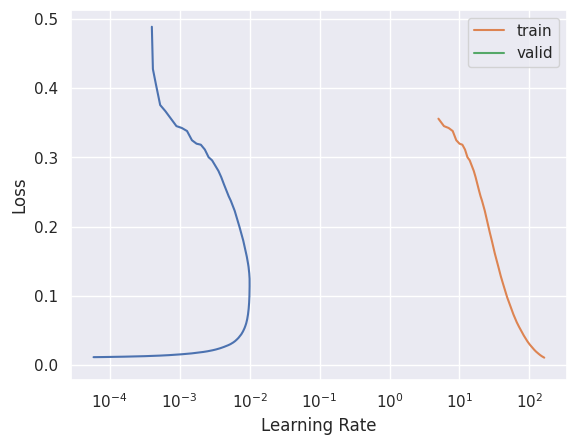

In [15]:
vector_data = pd.DataFrame(experiment_2A3_MaP['vectors'].to_list(), columns=[f'feature_{i}' for i in range(100)])
exp_2a3 = pd.concat([experiment_2A3_MaP, vector_data], axis=1).drop(columns='vectors')

cont_names = [f'feature_{i}' for i in range(100)]
dep_var = 'reactivity'

splits = RandomSplitter(valid_pct=0.3)(range_of(exp_2a3))  # 70% train, 30% validation
to = TabularPandas(exp_2a3, procs=[Normalize], cont_names=cont_names, y_names=dep_var, splits=splits)

dls = to.dataloaders(bs=64)
learn = tabular_learner(dls, layers=[300,200], metrics=mae)

learn.lr_find(start_lr=1e-7, end_lr=10, num_it=100)

learn.fit_one_cycle(1, 1e-2)

learn.recorder.plot_lr_find()

learn.recorder.plot_loss()

In [16]:
del vector_data
del exp_2a3
del experiment_DMS_MaP
del experiment_2A3_MaP
del df
gc.collect()

31735

# It's a Sequence to Sequence Problem, Let's approach it using Seq-to-Seq RNN

# Data Preprocessing

In [17]:
rna_sequence_data = pd.read_csv('/kaggle/input/stanford-ribonanza-rna-folding/train_data.csv', nrows = 150000)
rna_sequence_data.head()

,sequence_id,sequence,experiment_type,dataset_name,reads,signal_to_noise,SN_filter,reactivity_0001,reactivity_0002,reactivity_0003,...,reactivity_error_0197,reactivity_error_0198,reactivity_error_0199,reactivity_error_0200,reactivity_error_0201,reactivity_error_0202,reactivity_error_0203,reactivity_error_0204,reactivity_error_0205,reactivity_error_0206
0,8cdfeef009ea,GGGAACGACUCGAGUAGAGUCGAAAAACGUUGAUAUGGAUUUACUCCGAGGAGACGAACUACCACGAACAGGGGAAACUCUACCCGUGGCGUCUCCGUUUGACGAGUAAGUCCUAAGUCAACAUGCCACGCGGGUCCUUCGGGACCCGCAAAAGAAACAACAACAACAAC,2A3_MaP,15k_2A3,2343,0.944,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,51e61fbde94d,GGGAACGACUCGAGUAGAGUCGAAAAACAUUGAUAUGGAUUUACUCCGAGGAGACGAACUACCACGAACAGGGGAAACUCUACCCGUGGCGUCUCCGUUUGACGAGUAAGUCCUAAGUCAACAUGCACAGCGCUGGGUUCGCCCAGCGCAAAAGAAACAACAACAACAAC,2A3_MaP,15k_2A3,5326,1.933,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,25ce8d5109cd,GGGAACGACUCGAGUAGAGUCGAAAAACCUUGAUAUGGAUUUACUCCGAGGAGACGAACUACCACGAACAGGGGAAACUCUACCCGUGGCGUCUCCGUUUGACGAGUAAGUCCUAAGUCAACAUGCAUGGGUCCUCCUUCGGGAGGACCAAAAGAAACAACAACAACAAC,2A3_MaP,15k_2A3,4647,2.347,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,07dcfb6d1965,GGGAACGACUCGAGUAGAGUCGAAAAACUUUGAUAUGGAUUUACUCCGAGGAGACGAACUACCACGAACAGGGGAAACUCUACCCGUGGCGUCUCCGUUUGACGAGUAAGUCCUAAGUCAACAUGCCAGGUAUUGACUUCGGUCAAUACAAAAGAAACAACAACAACAAC,2A3_MaP,15k_2A3,102843,11.824,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,e561cc042a4c,GGGAACGACUCGAGUAGAGUCGAAAAACGAUGAUAUGGAUUUACUCCGAGGAGACGAACUACCACGAACAGGGGAAACUCUACCCGUGGCGUCUCCGUUUGACGAGUAAGUCCUAAGUCAACAUGCAUGCAUGCGGCUUCGGCCGCAUGAAAAGAAACAACAACAACAAC,2A3_MaP,15k_2A3,7665,3.519,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
rna_sequence_data = rna_sequence_data.drop(columns=rna_sequence_data.filter(like='error').columns)
rna_sequence_data = rna_sequence_data.drop(['sequence_id', 'dataset_name', 'reads', 'SN_filter'], axis=1)
reactivity_cols = rna_sequence_data.filter(like='reactivity').columns
rna_sequence_data[reactivity_cols] = rna_sequence_data[reactivity_cols].clip(lower=0)
row_means = rna_sequence_data[reactivity_cols].mean(axis=1)
rna_sequence_data[reactivity_cols] = rna_sequence_data[reactivity_cols].apply(lambda col: col.fillna(row_means))
rna_sequence_data[reactivity_cols] = rna_sequence_data[reactivity_cols].fillna(0)

def encode_nucleotide(nucleotide):
    mapping = {'A': [1, 0, 0, 0],
               'U': [0, 1, 0, 0],
               'G': [0, 0, 1, 0],
               'C': [0, 0, 0, 1]}
    return mapping[nucleotide]

def encode_sequence(sequence):
    return [encode_nucleotide(n) for n in sequence]

rna_sequence_data['encoded_sequence'] = rna_sequence_data['sequence'].apply(encode_sequence)

rna_sequence_data['padded_sequence'] = rna_sequence_data['encoded_sequence'].apply(lambda x: pad_sequences([x], maxlen=457, padding='post')[0])

def pad_reactivity_sequence(sequence, max_length=457, padding_value=-0.1):
    # Calculate how many padding values are needed
    padding_length = max_length - len(sequence)
    
    # Create the padded sequence
    padded_sequence = list(sequence) + [padding_value] * padding_length
    
    return padded_sequence

# 1. Consolidate Reactivity Columns
reactivity_columns = [f'reactivity_{i:04}' for i in range(1, 207)]  # Adjust this based on the number of columns you have

rna_sequence_data['reactivity'] = rna_sequence_data[reactivity_columns].values.tolist()

# Drop the individual reactivity columns as they're now redundant (optional)
rna_sequence_data.drop(columns=reactivity_columns, inplace=True)

# Apply the padding function
rna_sequence_data['padded_reactivity'] = rna_sequence_data['reactivity'].apply(pad_reactivity_sequence)

# 1. Store original sequence lengths
rna_sequence_data['original_length'] = rna_sequence_data['reactivity'].apply(len)

# 2. Inverse transform function
def inverse_transform(padded_sequence, original_length):
    return padded_sequence[:original_length]

# Apply the inverse transform
rna_sequence_data['retrieved_reactivity'] = rna_sequence_data.apply(lambda row: inverse_transform(row['padded_reactivity'], row['original_length']), axis=1)

/tmp/ipykernel_25/458526684.py:19: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_25/458526684.py:21: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_25/458526684.py:35: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [19]:
rna_2A3 = rna_sequence_data[rna_sequence_data['experiment_type'] == '2A3_MaP']
rna_dms = rna_sequence_data[rna_sequence_data['experiment_type'] == 'DMS_MaP']

del rna_sequence_data
gc.collect()

0

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class RNASeq2SeqModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_layers):
        super(RNASeq2SeqModel, self).__init__()
        
        # Input is 4 due to one-hot encoding of A, U, G, C
        self.embedding = nn.Embedding(4, embedding_dim)  # Embedding layer
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)  # Predicting reactivity for each nucleotide
        
    def forward(self, x):
        x = torch.argmax(x, dim=-1)  # Convert one-hot to indices for embedding
        x = self.embedding(x)
        rnn_out, _ = self.rnn(x)
        output = self.fc(rnn_out)
        return output

    
sequence_matrix = rna_2A3['padded_sequence']
sequence_tensor = torch.FloatTensor(sequence_matrix)
reactivities = torch.FloatTensor(rna_2A3['padded_reactivity'])


/tmp/ipykernel_25/2420773037.py:21: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:245.)



# Training RNN Seq-to-Seq on 2A3_MaP data

In [21]:
# Create Dataset
dataset = TensorDataset(sequence_tensor, reactivities)

# Split data into train and validation sets (80% train, 20% validation for this example)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Hyperparameters
embedding_dim = 16
hidden_dim = 32
num_layers = 2
learning_rate = 0.001
num_epochs = 100

# Instantiate model
model_2a3 = RNASeq2SeqModel(embedding_dim=16, hidden_dim=32, num_layers=2).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_2a3.parameters(), lr=0.001)

for epoch in range(num_epochs):
    
    model_2a3.train()
    total_loss = 0.0
    
    for batch_seq, batch_react in train_loader:
        
        batch_seq, batch_react = batch_seq.to(device), batch_react.to(device) 
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model_2a3(batch_seq)
        
        # Compute loss
        loss = criterion(outputs.squeeze(), batch_react)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # Validate and compute MSE for the validation set
    model_2a3.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_seq, batch_react in val_loader:
            batch_seq, batch_react = batch_seq.to(device), batch_react.to(device)  # Transfer data to GPU
            outputs = model_2a3(batch_seq)
            loss = criterion(outputs.squeeze(), batch_react)
            val_loss += loss.item()
        
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {total_loss/len(train_loader)}, Validation MSE: {val_loss/len(val_loader)}")

print("Training finished.")

Epoch 1/100, Training Loss: 0.21599517570439178, Validation MSE: 0.2081085977085093
Epoch 2/100, Training Loss: 0.2110401716059459, Validation MSE: 0.20497512154756709
Epoch 3/100, Training Loss: 0.20828419556813454, Validation MSE: 0.20190537717748194
Epoch 4/100, Training Loss: 0.20611610887115445, Validation MSE: 0.20067387036186585
Epoch 5/100, Training Loss: 0.20475562673006484, Validation MSE: 0.19912514832425623
Epoch 6/100, Training Loss: 0.20363273623306105, Validation MSE: 0.1983044153198283
Epoch 7/100, Training Loss: 0.2027629719439473, Validation MSE: 0.1982092964522382
Epoch 8/100, Training Loss: 0.2021500013752787, Validation MSE: 0.1972352126177321
Epoch 9/100, Training Loss: 0.2017405062341995, Validation MSE: 0.19734299331903457
Epoch 10/100, Training Loss: 0.20142754048966904, Validation MSE: 0.1965879092508174
Epoch 11/100, Training Loss: 0.20101148545392541, Validation MSE: 0.19613843097331676
Epoch 12/100, Training Loss: 0.20048646543071721, Validation MSE: 0.1957

In [22]:
del dataset
del train_dataset
del val_dataset
del train_loader
del val_loader
del sequence_tensor
del reactivities

gc.collect()

0

# Training RNN Seq-to-Seq on DMS_MaP data

In [23]:
sequence_matrix_dms = np.stack(rna_dms['padded_sequence'].to_numpy())  # Convert Series of lists to a numpy array
sequence_tensor_dms = torch.FloatTensor(sequence_matrix_dms)
reactivities_dms = torch.FloatTensor(np.stack(rna_dms['padded_reactivity'].to_numpy()))

# Create Dataset for rna_dms
dataset_dms = TensorDataset(sequence_tensor_dms, reactivities_dms)

# Split data into train and validation sets (80% train, 20% validation for this example)
train_size_dms = int(0.8 * len(dataset_dms))
val_size_dms = len(dataset_dms) - train_size_dms
train_dataset_dms, val_dataset_dms = random_split(dataset_dms, [train_size_dms, val_size_dms])

train_loader_dms = DataLoader(train_dataset_dms, batch_size=64, shuffle=True)
val_loader_dms = DataLoader(val_dataset_dms, batch_size=64, shuffle=False)

In [24]:
# Instantiate another model for rna_dms
model_dms = RNASeq2SeqModel(embedding_dim=embedding_dim, hidden_dim=hidden_dim, num_layers=num_layers).to(device)
optimizer_dms = torch.optim.Adam(model_dms.parameters(), lr=learning_rate)

# Training Loop for rna_dms
for epoch in range(num_epochs):
    model_dms.train()
    total_loss = 0.0
    for batch_seq, batch_react in train_loader_dms:
        batch_seq, batch_react = batch_seq.to(device), batch_react.to(device) 
        optimizer_dms.zero_grad()
        
        # Forward pass
        outputs = model_dms(batch_seq)
        
        # Compute loss
        loss = criterion(outputs.squeeze(), batch_react)
        
        # Backward pass and optimize
        loss.backward()
        optimizer_dms.step()
        
        total_loss += loss.item()
    
    # Validate and compute MSE for the validation set
    model_dms.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_seq, batch_react in val_loader_dms:
            batch_seq, batch_react = batch_seq.to(device), batch_react.to(device)  # Transfer data to GPU
            outputs = model_dms(batch_seq)
            loss = criterion(outputs.squeeze(), batch_react)
            val_loss += loss.item()
        
    
    print(f"[DMS] Epoch {epoch+1}/{num_epochs}, Training Loss: {total_loss/len(train_loader_dms)}, Validation MSE: {val_loss/len(val_loader_dms)}")

print("Training for DMS finished.")

[DMS] Epoch 1/100, Training Loss: 0.21593143258775985, Validation MSE: 0.20947693957293287
[DMS] Epoch 2/100, Training Loss: 0.20663076536710073, Validation MSE: 0.20435691789743748
[DMS] Epoch 3/100, Training Loss: 0.2035889289717176, Validation MSE: 0.20251790031473688
[DMS] Epoch 4/100, Training Loss: 0.20175184288830644, Validation MSE: 0.20123294563369548
[DMS] Epoch 5/100, Training Loss: 0.20072772979799872, Validation MSE: 0.20012952453912572
[DMS] Epoch 6/100, Training Loss: 0.19991124617551437, Validation MSE: 0.19948244792349795
[DMS] Epoch 7/100, Training Loss: 0.19957659822473647, Validation MSE: 0.19923080256644715
[DMS] Epoch 8/100, Training Loss: 0.19917880468912472, Validation MSE: 0.1990411585315745
[DMS] Epoch 9/100, Training Loss: 0.19882894889600494, Validation MSE: 0.19854594820991475
[DMS] Epoch 10/100, Training Loss: 0.1985617092153284, Validation MSE: 0.1983400192666561
[DMS] Epoch 11/100, Training Loss: 0.1981987465482785, Validation MSE: 0.19795466940453713
[D

In [25]:
torch.save(model_dms, "/kaggle/working/models/model_dms.pth")
torch.save(model_2a3, "/kaggle/working/models/model_2a3.pth")